In [1]:
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.ml.feature import PCA, RFormula
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

### Connect to Spark

In [2]:
ss = SparkSession.Builder() \
     .appName("DashBoard") \
     .master("spark://post-batch-processing-spark-master:7077") \
     .getOrCreate()

### Read data from parquet file "trips.parquet" in hdfs

In [3]:
df = ss.read.parquet("hdfs://namenode:9000/trips/trips.parquet")

In [4]:
print(f"Number of records: {df.count()}")
df = df.sort('ArrivalTime')

Number of records: 1480


# Data Mining

### Distribution of trips over time

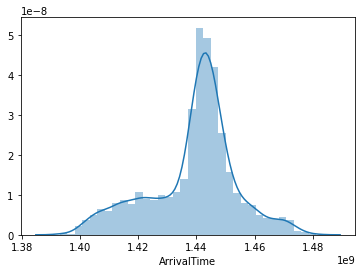

In [5]:
arrivalTime = df.select('ArrivalTime').toPandas()['ArrivalTime'].astype('int64')
sns.distplot(arrivalTime)

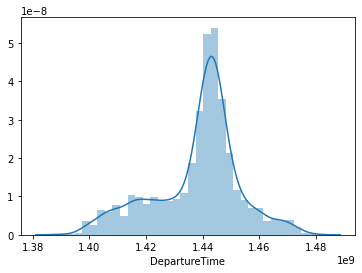

In [6]:
arrivalTime = df.select('DepartureTime').toPandas()['DepartureTime'].astype('int64')
sns.distplot(arrivalTime)

### Top 10 most visited destinations in the last year

In [7]:
arrivalTime = df.select('DepartureTime').toPandas()['DepartureTime'].astype('int32')
thirty_days = 86400 * 30 * 12
lastRecordTime = arrivalTime.iloc[-1]
pivot = int(lastRecordTime - thirty_days)
s = df.filter(df.DepartureTime > pivot).select('Destination')

In [8]:
s.head(10)

[Row(Destination='UME'),
 Row(Destination='MPM'),
 Row(Destination='BEG'),
 Row(Destination='LHR'),
 Row(Destination='MUC'),
 Row(Destination='HND'),
 Row(Destination='MAD'),
 Row(Destination='AAR'),
 Row(Destination='LAS'),
 Row(Destination='RGN')]

# Anomaly detection

### PCA

In [9]:
df = ss.read.parquet("hdfs://namenode:9000/trips/processed_trips.parquet")

In [10]:
print(f"Number of records: {df.count()}")
df = df.sort('ArrivalTime')

Number of records: 1775


In [11]:
df = df.select(
    'ArrivalTime',
    'BusinessLeisure',
    'CabinCategory',
    'CreationDate',
    'CurrencyCode',
    'DepartureTime',
    'Destination',
    'OfficeIdCountry',
    'Origin',
    'TotalAmount',
    'nPAX'
)

In [12]:
pca = PCA().setInputCol("features").setK(2)
data = RFormula(formula=" ~ {0}".format(" + ".join(df.columns))).fit(df).transform(df)
s = pca.fit(data).transform(data)
r = s.select(s.columns[-1]).toPandas()[s.columns[-1]]

X = []
Y = []
for i in range(len(r)):
    X.append(r[i][0])
    Y.append(r[i][1])

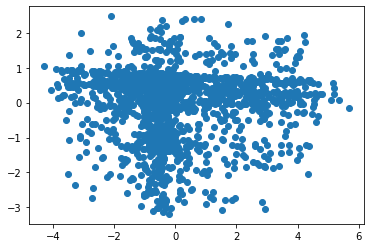

In [13]:
plt.scatter(X, Y)